## GPyTorch

Our aim: 
- given a known model (currently GP with various priors)
- and a ground truth
- infer "missing values"


GPyTorch's approach:
- setup very simple model
- 1 single piece of training data to observe
- test_x: set of points 

Final setup:
- setup the model, with the same priors
- observe the ground truth (only observation locations)
- predict at full set of locations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from jax import random
import jax.numpy as jnp
import numpy as onp
import numpyro
import spacv
import time
from reusable.geo import load_state_centroids, centroids_to_coords, get_processed_temp_data
numpyro.set_host_device_count(3)
from plotting.ny import plot_multi_on_state, plot_on_state
from reusable.split import calculate_obs_fracs, calculate_spatial_cv, generate_split_titles
from reusable.gp import BuildGP
from reusable.util import gen_file_name


/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/spacv/spacv.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS 

In [3]:
from reusable.kernels import esq_kernel

args = {
    # geographic data
    "state": 36,  # New York
    # ground truth
    "year": 2010,
    "aggr_method": 127, # "mean",
    "coord_scaling_factor": 1e5,
    # GP prior configuration
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}

state_centroids = load_state_centroids(args["state"])
coords = torch.from_numpy(onp.array(centroids_to_coords(state_centroids, args["coord_scaling_factor"])[0]))

args.update(
    {  # so we can use the definition of n to define x
        "x": coords,
        "n": coords.shape[0],
        "length_prior_choice": "invgamma",
        "length_prior_arguments": {"concentration": 4.0, "rate": 1.0},
        "variance_prior_choice": "gamma",
        "variance_prior_arguments": {"concentration": 5.25, "rate": 0.5},
        "expcode": "24",
        "num_cv_splits": 5,
        "obs_fracs": [0.01, 0.05, 0.10, 0.2, 0.3],
        "observations_rng_key": random.PRNGKey(123456789),
    }
)

gp = BuildGP(
    args["gp_kernel"],
    noise=True,
    length_prior_choice=args["length_prior_choice"],
    length_prior_args=args["length_prior_arguments"],
    variance_prior_choice=args["variance_prior_choice"],
    variance_prior_args=args["variance_prior_arguments"],
)


args["ground_truth"], args["temp_mean_offset"] = get_processed_temp_data(
    args["state"], args["year"], args["aggr_method"]
)

ground_truth_torch = torch.from_numpy(args["ground_truth"]).long()


rng_key_observations, rng_key_spatial_cv = random.split(args["observations_rng_key"], 2)


obs_idx_lst = calculate_obs_fracs(args["obs_fracs"], args["n"], rng_key_observations) + calculate_spatial_cv(
    args["num_cv_splits"], state_centroids["geometry"], args["n"], rng_key_spatial_cv
)
obs_idx_lst = [torch.tensor(onp.array(a)) for a in obs_idx_lst]
titles_lst = generate_split_titles(args["obs_fracs"], args["n"], args["num_cv_splits"])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Mean 10.5 Variance 21.0
127
         zcta      tmean        date day month    year
226044  06390  17.004604  07/05/2010  07    05  2010.0
226045  10001  19.194566  07/05/2010  07    05  2010.0
226046  10002  19.112296  07/05/2010  07    05  2010.0
226047  10003  19.194566  07/05/2010  07    05  2010.0
226048  10004  19.097191  07/05/2010  07    05  2010.0
...       ...        ...         ...  ..   ...     ...
227833  14898  10.181310  07/05/2010  07    05  2010.0
227834  14901  10.971254  07/05/2010  07    05  2010.0
227835  14903  10.912447  07/05/2010  07    05  2010.0
227836  14904  11.405346  07/05/2010  07    05  2010.0
227837  14905  11.201444  07/05/2010  07    05  2010.0

[1794 rows x 6 columns]


/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [4]:
from torch.nn import Module as TModule


class InverseGammaPrior(gpytorch.priors.Prior, torch.distributions.TransformedDistribution):
    """Gamma Prior parameterized by concentration and rate

    pdf(x) = beta^alpha / Gamma(alpha) * x^(alpha - 1) * exp(-beta * x)

    where alpha > 0 and beta > 0 are the concentration and rate parameters, respectively.
    """

    def __init__(self, concentration, rate, validate_args=False, transform=None):
        TModule.__init__(self)
        base_dist = torch.distributions.Gamma(concentration, rate)
        torch.distributions.TransformedDistribution.__init__(
            self,
            base_dist,
            torch.distributions.PowerTransform(-base_dist.rate.new_ones(())),
            validate_args=validate_args,
        )
        #_bufferize_attributes(self, ("concentration", "rate"))
        self._transform = transform

    def expand(self, batch_shape):
        batch_shape = torch.Size(batch_shape)
        return InverseGammaPrior(self.concentration.expand(batch_shape), self.rate.expand(batch_shape))

    def __call__(self, *args, **kwargs):
        return super(torch.distributions.TransformedDistribution, self).__call__(*args, **kwargs)


In [5]:
def args_to_prior(choice, args):
    if choice == "invgamma":
        conc = args.get("concentration", 4)
        rate = args.get("rate", 1)
        return InverseGammaPrior(conc, rate)

    elif choice == "lognormal":
        loc = args.get("location", 0.0)
        scale = args.get("scale", 0.1)
        return gpytorch.priors.LogNormalPrior(loc, scale)

    elif choice == "normal":
        loc = args.get("location", 0.0)
        scale = args.get("scale", 15.0)
        return gpytorch.priors.NormalPrior(loc, scale)

    elif choice == "halfnormal":
        scale = args.get("scale", 15.0)
        return gpytorch.priors.HalfNormalPrior(scale)

    elif choice == "gamma":
        conc = args.get("concentration", 4)
        rate = args.get("rate", 1)
        return gpytorch.priors.GammaPrior(conc, rate)

    elif choice == "uniform":
        lower = args.get("lower", 0.01)
        upper = args.get("upper", 0.5)
        return gpytorch.priors.UniformPrior(lower, upper)


# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=args_to_prior(args["length_prior_choice"], args["length_prior_arguments"])),
            outputscale_prior=args_to_prior(args["variance_prior_choice"], args["variance_prior_arguments"]),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


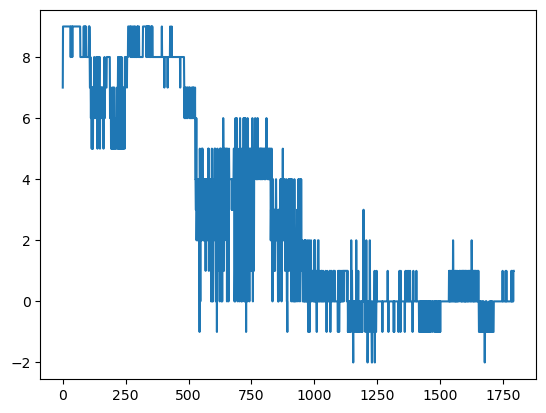

In [6]:
plt.plot(onp.arange(args["n"]), ground_truth_torch)

In [7]:
args["x"]

tensor([[ 2.9780, -0.2903],
        [ 1.4595, -1.4188],
        [ 1.4808, -1.4551],
        ...,
        [-1.4063, -0.5812],
        [-1.3265, -0.6258],
        [-1.3688, -0.6153]])

In [8]:
# Training data is 100 points in [0,1] inclusive regularly spaced

#indices = torch.linspace(0, 98, 50, dtype=int)

train_xs = [args["x"][indices] for indices in obs_idx_lst]

train_plot_xs = [indices/ args["n"] for indices in obs_idx_lst]
# True function is sin(2*pi*x) with Gaussian noise
train_ys = [ground_truth_torch[indices] for indices in obs_idx_lst]

tensor([[6.9315e-01, 1.6715e-02, 1.6390e-02,  ..., 1.3024e-09, 2.6031e-09,
         1.7924e-09],
        [1.6715e-02, 6.9315e-01, 6.9187e-01,  ..., 6.4809e-05, 1.1179e-04,
         8.5819e-05],
        [1.6390e-02, 6.9187e-01, 6.9315e-01,  ..., 5.3474e-05, 9.2873e-05,
         7.1109e-05],
        ...,
        [1.3024e-09, 6.4809e-05, 5.3474e-05,  ..., 6.9315e-01, 6.8714e-01,
         6.9129e-01],
        [2.6031e-09, 1.1179e-04, 9.2873e-05,  ..., 6.8714e-01, 6.9315e-01,
         6.9178e-01],
        [1.7924e-09, 8.5819e-05, 7.1109e-05,  ..., 6.9129e-01, 6.9178e-01,
         6.9315e-01]], grad_fn=<MulBackward0>)
torch.Size([1794])
Done
tensor(0.2902) tensor(0.4727)


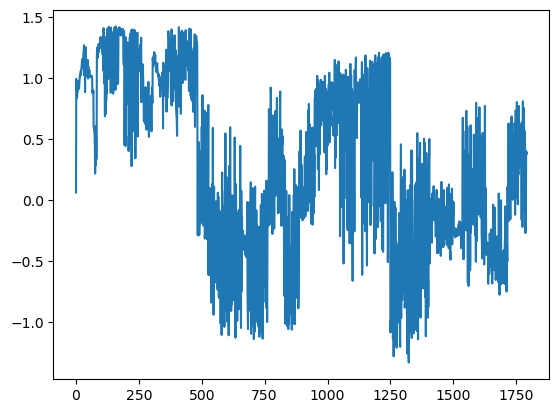

In [9]:
N=1000

test_x = torch.randn((args["n"], N))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
sample_model = ExactGPModel(args["x"], ground_truth_torch, likelihood)

hypers = {
    # We won't be using the likelihood so we don't need to initialize the noise
    'covar_module.base_kernel.lengthscale': torch.tensor([1.0]),
    'covar_module.outputscale': torch.tensor(4.0),
}

sample_model.initialize()#**hypers)

sample_model.eval()
    

with gpytorch.settings.prior_mode(True):
    output_dist = sample_model(args["x"])
    print(output_dist.covariance_matrix)
    sample = output_dist.sample() # torch.linspace(0, 1, N).size()\


print(sample.shape)

plt.plot(onp.arange(0, args["n"]), sample )
print("Done")

print(sample.mean(), sample.var())

In [10]:
def train_model(train_x, train_y, training_iter=1000):
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % 100 ==0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

    return model, likelihood

In [11]:
def evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        print(model(test_x).covariance_matrix)
        observed_pred = likelihood(model(test_x))
    with torch.no_grad():
        # Initialize plot

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
    return observed_pred.mean.numpy(), lower.numpy(), upper.numpy()


def plot_evaluations(train_xs, train_ys, test_x, observed_means, lowers, uppers, max_per_row=2):
    assert len(observed_means) == len(lowers) and len(lowers) == len(uppers)

    num_per_row = min(max_per_row, len(observed_means))
    num_rows = (len(observed_means) + num_per_row -1) // num_per_row


    f, axs = plt.subplots(num_rows, num_per_row, figsize=(num_per_row *10, num_rows * 6))
    
    for i in range(len(observed_means)):
        # Plot training data as black stars
        axs.flat[i].plot(train_xs[i], train_ys[i], 'k*')
        # Plot predictive means as blue line
        axs.flat[i].plot(test_x, observed_means[i], 'b')

        axs.flat[i].plot(test_x, ground_truth_torch.to_numpy(), 'r')
        # Shade between the lower and upper confidence bounds
        axs.flat[i].fill_between(test_x, lowers[i], uppers[i], alpha=0.5)
        axs.flat[i].set_ylim([2.5, 15])
        axs.flat[i].legend(['Observed Data', 'Mean', "Ground truth (with noise)", 'Confidence'])
        axs.flat[i].set_title(f"{len(obs_idx_lst[i])} observed points")

In [12]:
means = []
lowers = []
uppers = []


for i in range(len(obs_idx_lst)):
    start = time.time()
    model, likelihood = train_model(train_xs[i], train_ys[i])
    train_end = time.time()
    mean, lower, upper = evaluate_model(model, likelihood, args["x"])
    eval_end = time.time()
    print(f"Run {i} done, train in {train_end - start}s, eval in {eval_end - train_end}s")
    means.append(mean)
    lowers.append(lower)
    uppers.append(upper)


Iter 1/1000 - Loss: 5.175   lengthscale: 0.693   noise: 0.693
Iter 101/1000 - Loss: 2.017   lengthscale: 0.762   noise: 0.150
Iter 201/1000 - Loss: 1.925   lengthscale: 0.793   noise: 0.133
Iter 301/1000 - Loss: 1.899   lengthscale: 0.813   noise: 0.130
Iter 401/1000 - Loss: 1.890   lengthscale: 0.826   noise: 0.128
Iter 501/1000 - Loss: 1.885   lengthscale: 0.834   noise: 0.127
Iter 601/1000 - Loss: 1.884   lengthscale: 0.840   noise: 0.127
Iter 701/1000 - Loss: 1.883   lengthscale: 0.844   noise: 0.126
Iter 801/1000 - Loss: 1.883   lengthscale: 0.846   noise: 0.126
Iter 901/1000 - Loss: 1.883   lengthscale: 0.848   noise: 0.126
tensor([[ 2.3426e+00, -3.6099e-02, -3.5446e-02,  ..., -1.2538e-03,
         -8.0015e-04, -9.9105e-04],
        [-3.6099e-02,  1.0224e-01,  1.0529e-01,  ...,  1.4183e-03,
          2.4234e-03,  1.9382e-03],
        [-3.5446e-02,  1.0529e-01,  1.1034e-01,  ...,  8.0539e-05,
          8.7442e-04,  5.0681e-04],
        ...,
        [-1.2538e-03,  1.4183e-03,  8.05

3 5


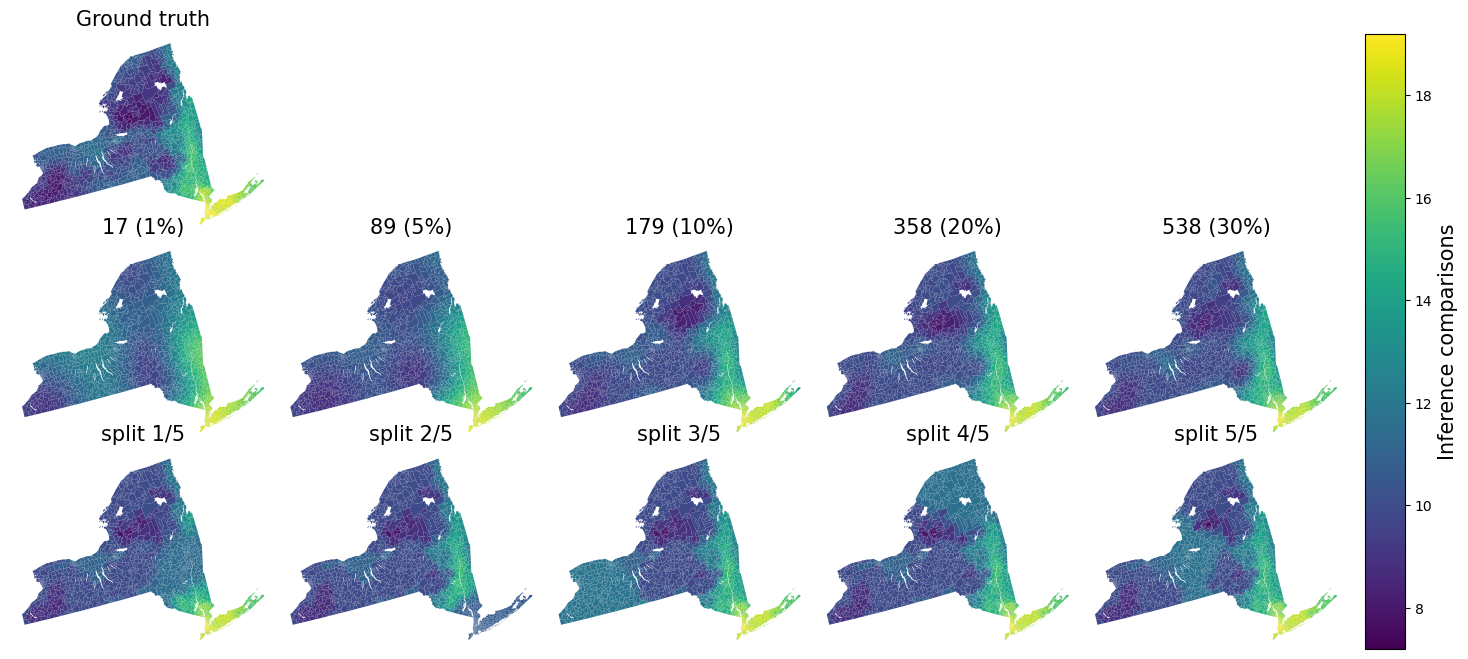

In [13]:
plot_multi_on_state( onp.array([args["ground_truth"]] +means)+ args["temp_mean_offset"], 36, "Inference comparisons", None, ["Ground truth"] +  titles_lst, num_in_row=5, save_file_name = "25/"+ gen_file_name(25, args, "observed_means" +  f"{args['state']}_{args['year']}_{args['aggr_method']}"
), backfill="align_left")

In [14]:
masks = []
for x in obs_idx_lst:
    t = torch.zeros(args["n"])
    t[x] = 1
    masks.append(t.numpy())

2 5


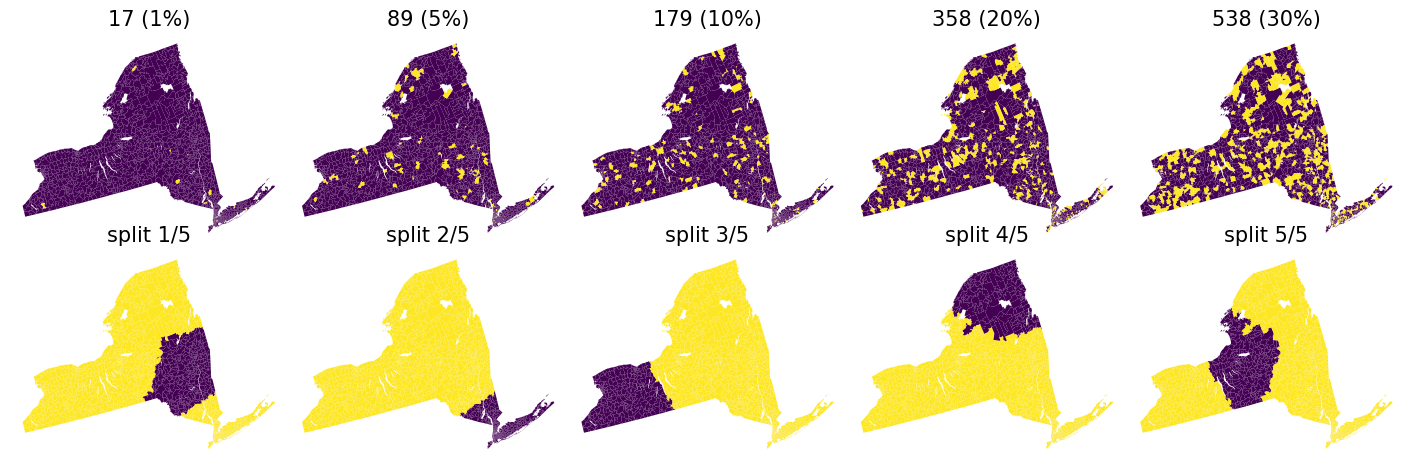

In [15]:

plot_multi_on_state(onp.array(masks), 36, None, None, titles_lst, save_file_name ="25/"+ gen_file_name(25, args, "obs_points"), num_in_row=5, show_cbar=False )


2 5


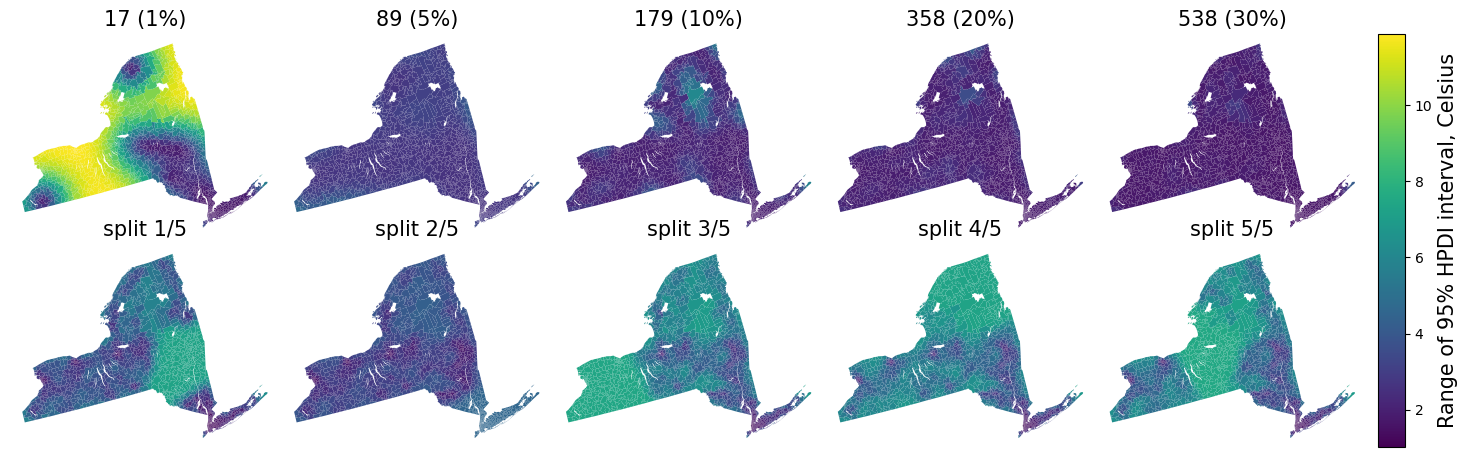

In [16]:
plot_multi_on_state(onp.array([u - l for u,l in zip(uppers, lowers)]), 36,  "Range of 95% HPDI interval, Celsius",  None,  titles_lst, save_file_name = "25/"+ gen_file_name(25, args, "hpdi_diffs" +  f"{args['state']}_{args['year']}_{args['aggr_method']}"
), num_in_row=5)

In [20]:
import pandas as pd

df = pd.DataFrame(columns=["Loss function"] + titles_lst[:5] + ["Spatial CV"])


mses = [ float(jnp.mean(jnp.power(x - args["ground_truth"],2 )))  for x in means]

sqrts = [float(jnp.sqrt(x)) for x in mses]


print("MSEs")
print(mses[:5])
print("RMSEs")
print(sqrts[:5])

print("Spatial CV MSE")
print(onp.mean(mses[5:]))
print("RMSEs")
print(onp.mean(sqrts[5:]))

df.loc[0] = (["MLE with GPyTorch"] + mses[:5] + [onp.mean(mses[5:])])

df= df.set_index("Loss function")  
s = df.style
s.format("{:1.3f}")
print(s.to_latex())

MSEs
[1.31637442111969, 0.6885051131248474, 0.43702974915504456, 0.3440721333026886, 0.3436104655265808]
RMSEs
[1.1473336219787598, 0.8297621011734009, 0.6610822677612305, 0.5865766406059265, 0.5861829519271851]
Spatial CV MSE
4.064588570594788
RMSEs
1.5598038196563722
\begin{tabular}{lrrrrrr}
 & 17 (1%) & 89 (5%) & 179 (10%) & 358 (20%) & 538 (30%) & Spatial CV \\
Loss function &  &  &  &  &  &  \\
MLE with GPyTorch & 1.316 & 0.689 & 0.437 & 0.344 & 0.344 & 4.065 \\
\end{tabular}

